In [21]:
from astropy.io import fits
from astropy.stats import sigma_clip
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import ImageNormalize, ZScaleInterval
from astropy.io import fits
from astropy.table import QTable, hstack
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from photutils.aperture import ApertureStats
from photutils.profiles import RadialProfile

In [30]:
def do_aperture_photometry(
    image,
    positions,
    radii,
    sky_radius_in,
    sky_annulus_width,
):
    """This function:

    - Accept a fully reduced science image as a file and read it.
    - Accept a list of positions on the image as a list of tuples (x, y).
    - Accept a list of aperture radii as a list of floats.
    - Accept a the radius at which to measure the sky background as sky_radius_in.
    - Accept a the width of the annulus as sky_annulus_width.
    - For each position and radius, calculate the flux in the aperture, subtracting
      the sky background. You can do this any way that you like but probably you'll
      want to use SkyCircularAnnulus from photutils.
    - The function should return the results from the aperture photometry. Usually
      this will be an astropy table from calling photutils aperture_photometry, but
      it can be something different if you use a different library.

    Note that the automated tests just check that you are returning from this
    function, but they do not check the contents of the returned data.

    """
    #Step Loading science image (reduced)
    data = fits.getdata(image)
    #Step Initializing list of 
    results = []

    for radius in radii:
    #Step Aperture and annulus
        aperture = CircularAperture(positions, r=radius)
        annulus = CircularAnnulus(positions, r_in=sky_radius_in, r_out=sky_radius_in + sky_annulus_width)

    #Step Doing photometry
        phot_ap = aperture_photometry(data, aperture)
        phot_an = aperture_photometry(data, annulus)

    #Step estimating background
        annulus_stats = ApertureStats(data, annulus)
        bkg_median = annulus_stats.median
        bkg_total = bkg_median * aperture.area

    #Step minus background
        phot_ap[f'flux_r{radius}'] = phot_ap['aperture_sum'] - bkg_total

    #Step into the results
        results.append(phot_ap[[f'flux_r{radius}']])
        
    #Step Merging
    base_table = QTable(positions, names=('xcenter', 'ycenter'))
    result = hstack([base_table] + results)
    result.meta['sky_radius_in'] = sky_radius_in   # storing the sky_raaidus in to later be read by radial plot function
    #Step result
    return result

In [31]:
positions = [(1305.57, 1022.5), (786.009, 1115.66)]
radii = [5, 10, 25, 30, 35]
phot_table = do_aperture_photometry('reduced_kelt16b_C084.fits', positions, radii, 20, 5)
phot_table.pprint()

xcenter ycenter      flux_r5       ...      flux_r30           flux_r35     
------- ------- ------------------ ... ------------------ ------------------
1305.57 786.009 14754.479825307797 ... 25983.688669610798  25739.04896813567
 1022.5 1115.66 15446.906238131038 ... 28111.627285831943 29071.775270764716


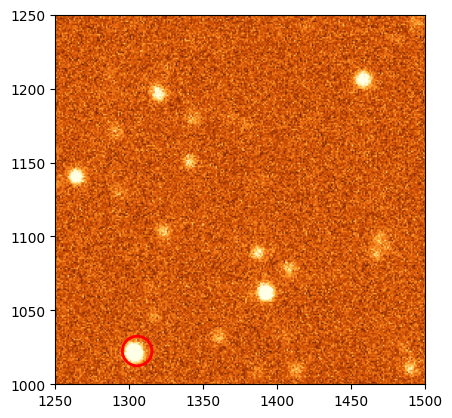

In [10]:
ccd37_proc = fits.open('reduced_kelt16b_C084.fits')
ccd37_proc_data = ccd37_proc[0].data.astype('f4')
norm = ImageNormalize(ccd37_proc_data, interval=ZScaleInterval())

# Define the aperture
aperture = CircularAperture((1305.57, 1022.5), r=10)

# Plot the aperture on top of the image
_ = plt.imshow(ccd37_proc_data, origin='lower', norm=norm, cmap='YlOrBr_r')
_ = aperture.plot(color='red', lw=2, label='Aperture')
_ = plt.xlim(1250, 1500)
_ = plt.ylim(1000, 1250)

In [32]:
def plot_radial_profile(aperture_photometry_data, output_filename="radial_profile.png"):
    """This function must:

    - Accept a table of aperture photometry data as aperture_photometry_data. This
      is probably a photutils table, the result of do_aperture_photometry, but you
      can pass anything you like. The table/input data can contain a single target
      or multiple targets, but it must include multiple apertures.
    - Plot the radial profile of a target in the image using matplotlib. If you
      have multiple targets, label them correctly.
    - Plot a vertical line at the radius of the sky aperture used for the photometry.
    - Save the plot to the file specified in output_filename.

    """
    # Step 1: Identifing different radiuses from column names like 'flux_r5', 'flux_r10'
    radius_cols = [col for col in aperture_photometry_data.colnames if col.startswith('flux_r')]
    
    # Extract radius by splitting flux_r and 5. Mayeb not the most effeiceint way
    radii = [float(col.split('flux_r')[1]) for col in radius_cols]

    # Step 2: Plot one line per star (row)
    plt.figure()
    for i, row in enumerate(aperture_photometry_data):
        #get flux values for each radiuses/radii
        fluxes = [row[col] for col in radius_cols]
        plt.plot(radii, fluxes, marker='o', label=f"Star {i+1}")

    # grabing from meta  sky radius.
    sky_r = aperture_photometry_data.meta.get('sky_radius_in', None)
    # 4. If we have a sky radius, draw the line
    if sky_r is not None:
        plt.axvline(x=sky_r, color='gray', linestyle='--', label='Sky radius')

    plt.xlabel("Aperture Radius (pixels)")
    plt.ylabel("Background-subtracted Flux (ADU)")
    plt.title("Radial Profile of Aperture Photometry")
    plt.grid(True)
    plt.legend()
    plt.savefig(output_filename)
    plt.close()
    pass


In [33]:
phot_table = do_aperture_photometry(
    image="reduced_kelt16b_C084.fits",
    positions=[(1305.57, 1022.5), (786.009, 1115.66)],
    radii= range(5, 25, 2),
    sky_radius_in=20,
    sky_annulus_width=5
)

In [34]:
plot_radial_profile(phot_table, output_filename="radial_profile.png")